In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [18]:
def preprocess_monk(file_name):
    '''
    load and preprocess data from the monk dataset
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None, names=['remove_this_column','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'], index_col=False)
    df.drop(columns='remove_this_column')

    x1 = np.array(df['x1'])
    x2 = np.array(df['x2'])
    x3 = np.array(df['x3'])
    x4 = np.array(df['x4'])
    x5 = np.array(df['x5'])
    x6 = np.array(df['x6'])
    target = np.array(df['target'])

    encoder = OneHotEncoder(sparse_output=False)

    x1_ =x1.reshape(-1, 1)
    # Fit and transform the data to one-hot encoding
    input_one_hot = encoder.fit_transform(x1_)
    inputs = [x2,x3,x4,x5,x6]

    for x in inputs:
        data =x.reshape(-1, 1)
        # Fit and transform the data to one-hot encoding
        one_hot_encoded = encoder.fit_transform(data)

        # Display the result
        #print("Original data:")
        #print(data)

        #print("\nOne-hot encoded data:")
        #print(one_hot_encoded)

        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    #print(input_one_hot.shape)
    #print(input_one_hot[0])
    #print(target)
    #target = 2 * target - 1 #to map from {0,1} to {-1,1}

    x = torch.tensor(input_one_hot, dtype=torch.float32)
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)
    return x, y

In [19]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


Training - Epoch [1/500], Loss: 0.2579, Accuracy: 0.5000
Test - Epoch [1/500], Loss: 0.2560,Accuracy: 0.5000
Training - Epoch [2/500], Loss: 0.2546, Accuracy: 0.5000
Test - Epoch [2/500], Loss: 0.2534,Accuracy: 0.5000
Training - Epoch [3/500], Loss: 0.2523, Accuracy: 0.5052
Test - Epoch [3/500], Loss: 0.2519,Accuracy: 0.5000
Training - Epoch [4/500], Loss: 0.2513, Accuracy: 0.5000
Test - Epoch [4/500], Loss: 0.2510,Accuracy: 0.5000
Training - Epoch [5/500], Loss: 0.2501, Accuracy: 0.5026
Test - Epoch [5/500], Loss: 0.2500,Accuracy: 0.5000
Training - Epoch [6/500], Loss: 0.2498, Accuracy: 0.4974
Test - Epoch [6/500], Loss: 0.2496,Accuracy: 0.5000
Training - Epoch [7/500], Loss: 0.2487, Accuracy: 0.5026
Test - Epoch [7/500], Loss: 0.2492,Accuracy: 0.4861
Training - Epoch [8/500], Loss: 0.2483, Accuracy: 0.5208
Test - Epoch [8/500], Loss: 0.2488,Accuracy: 0.4838
Training - Epoch [9/500], Loss: 0.2478, Accuracy: 0.5573
Test - Epoch [9/500], Loss: 0.2486,Accuracy: 0.4861
Training - Epoch [1

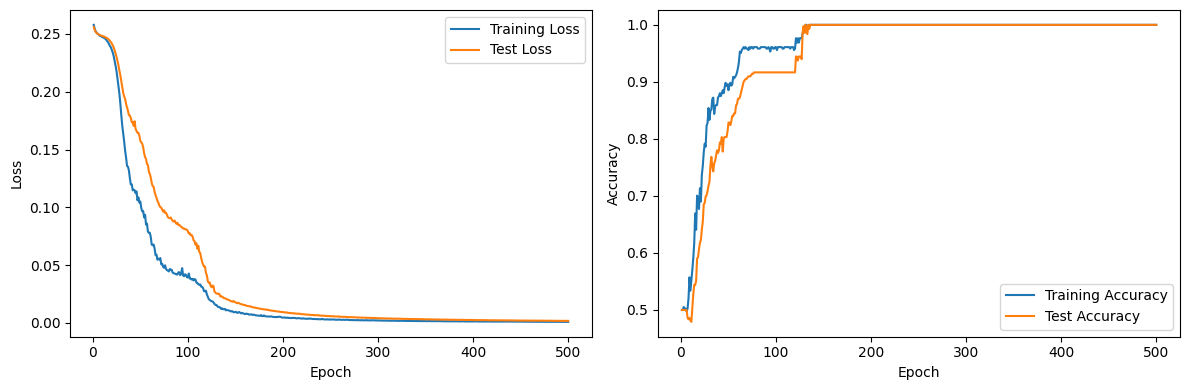

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        output = self.sigmoid(x)
        return output

# Set hyperparameters
input_size = 17
hidden_size = 5
output_size = 1
learning_rate = 0.1
momentum = 0.5
num_epochs = 500
bs = 16

# Create an instance of the model
model = SimpleClassifier(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)



# Lists to store training and test losses for plotting
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


for epoch in range(num_epochs):
    total_loss = 0.0
    total_accuracy = 0.0
    # Mini-batch training

    model.train()  # Set the model to training mode
    for inputs, labels in train_dataloader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate the total loss for this epoch
        total_loss += loss.item()

        # Calculate training accuracy
        predicted_labels = torch.round(outputs)
        correct_predictions = (predicted_labels == labels).sum().item()
        total_samples = labels.size(0)
        total_accuracy += correct_predictions / total_samples

    # Print average training loss and accuracy for the epoch
    average_loss = total_loss / len(train_dataloader)
    average_accuracy = total_accuracy / len(train_dataloader)

    print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, '
          f'Accuracy: {average_accuracy:.4f}')
    train_losses.append(average_loss)
    train_accuracies.append(average_accuracy)

    # Evaluation on the test set
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_test_loss = 0.0
        total_test_accuracy = 0.0
        for test_inputs, test_labels in test_dataloader:
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_labels)
            total_test_loss += test_loss.item()

            # Calculate test accuracy
            predicted_labels = torch.round(test_outputs)
            correct_predictions = (predicted_labels == test_labels).sum().item()
            total_samples = test_labels.size(0)
            total_test_accuracy += correct_predictions / total_samples

        average_test_loss = total_test_loss / len(test_dataloader)
        average_test_accuracy = total_test_accuracy / len(test_dataloader)

        print(f'Test - Epoch [{epoch+1}/{num_epochs}], Loss: {average_test_loss:.4f},'
               f'Accuracy: {average_test_accuracy:.4f}')

        test_accuracies.append(average_test_accuracy)
        test_losses.append(average_test_loss)

# Plot the training and test losses
plt.figure(figsize=(12, 4))

# Loss plots
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plots
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()